In [2]:
# import libraries
import numpy as np
import pandas as pd
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = '15'

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost.sklearn import XGBRegressor
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, Ridge

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, Normalizer, FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import FunctionTransformer
from scipy.stats import skew

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [3]:
# read the dataframe
data_path = 'solcast_cleaned_india.csv'
df = pd.read_csv(data_path, index_col=0)
df = df.drop(columns=['date'])    

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1097 entries, 0 to 1096
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temperature    1097 non-null   float64
 1   CloudOpacity   1097 non-null   float64
 2   DHI            1097 non-null   float64
 3   DNI            1097 non-null   float64
 4   Radiation      1097 non-null   float64
 5   Precipitation  1097 non-null   float64
 6   Humidity       1097 non-null   float64
 7   Pressure       1097 non-null   float64
 8   WindDirection  1097 non-null   float64
 9   WindSpeed      1097 non-null   float64
 10  Sunrise        1097 non-null   int64  
 11  Sunset         1097 non-null   int64  
 12  Month          1097 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 120.0 KB


## Split the data

In [5]:
from sklearn.model_selection import train_test_split 
# stratify also along the month column
# check that the rain ratio per month is equal between train and test set
df_train, df_test = train_test_split(df, test_size=0.25, stratify=df[['Month']]) 

print("Size of train:", round(len(df_train)/len(df)*100, 2), "% of original dataframe")
print("Size of test:", round(len(df_test)/len(df)*100, 2), "% of original dataframe")


Size of train: 74.93 % of original dataframe
Size of test: 25.07 % of original dataframe


In [6]:
def get_features_and_label(df):
    label = np.ravel(np.array(df['Radiation']).T)
    features = df.drop(columns=['Radiation']).to_numpy()
    return features, label

In [7]:
#Split the data into X and y
X_train, y_train = get_features_and_label(df_train)
X_test, y_test = get_features_and_label(df_test)

In [8]:
X_train.shape, y_train.shape

((822, 12), (822,))

## Modeling

In [9]:
skewed_features = []
for col in df_train.columns.to_list()[:-2]:    
    if col != 'Radiation':
        if((min(df_train[col]) > 0)) & (abs(skew(df_train[col])) > 0):
            skewed_features.append(col)
        
skewed_features

['Temperature',
 'DHI',
 'Precipitation',
 'Humidity',
 'Pressure',
 'WindDirection',
 'WindSpeed']

In [10]:
def log_transform(x):
    return np.log(x + 1)

In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ("month_encoder", OneHotEncoder(handle_unknown="ignore"), ['Month']),
        ("log_transform", FunctionTransformer(log_transform), skewed_features)
    ],
    remainder='passthrough'
)

In [12]:
pipeline = Pipeline([  
    ('preprocessing', preprocessor),
    ('scaler' , StandardScaler()),
    ('model' , RandomForestRegressor())
])

In [13]:
parameters = {
    'preprocessing__month_encoder': ['passthrough', OneHotEncoder(handle_unknown='ignore')],
    'preprocessing__log_transform': ['passthrough', FunctionTransformer(log_transform)],
    'scaler': ['passthrough', StandardScaler(), MinMaxScaler(), Normalizer(), RobustScaler()],
    'model': [LinearRegression(), RandomForestRegressor(), Ridge()]
}

In [14]:
X_train = df_train.drop(columns=['Radiation'])
y_train = df_train['Radiation']

X_test = df_test.drop(columns=['Radiation'])
y_test = df_test['Radiation']

In [15]:
X_train

,Temperature,CloudOpacity,DHI,DNI,Precipitation,Humidity,Pressure,WindDirection,WindSpeed,Sunrise,Sunset,Month
951,33.357143,76.928571,106.357143,8.857143,67.078571,53.528571,977.842857,85.500000,1.914286,9,16,8
1006,33.938462,20.461538,218.538462,189.923077,47.476923,43.800000,981.323077,227.923077,1.700000,9,0,10
537,38.950000,60.571429,155.785714,59.428571,42.864286,33.985714,974.028571,242.571429,2.607143,9,16,6
662,31.116667,12.150000,177.500000,341.416667,11.008333,14.475000,981.966667,200.416667,1.375000,9,0,10
717,14.572727,11.200000,93.636364,554.818182,4.127273,27.872727,994.418182,305.545455,3.554545,9,0,12
...,...,...,...,...,...,...,...,...,...,...,...,...
262,29.476923,51.492308,199.307692,46.461538,42.223077,61.930769,985.123077,103.615385,3.046154,9,0,9
947,32.642857,16.878571,285.285714,202.142857,57.121429,54.807143,974.985714,95.357143,3.878571,9,16,8
1076,20.154545,3.927273,132.909091,410.454545,7.818182,28.181818,993.263636,301.636364,1.872727,9,0,12
742,15.733333,14.383333,120.166667,399.416667,4.375000,36.366667,990.516667,304.833333,3.941667,9,0,1


In [16]:
scoring = {'max_error': 'max_error', 'neg_mean_squared_error': 'neg_mean_squared_error', 'r2':'r2'}

grid = GridSearchCV(pipeline, parameters, cv=5, scoring=scoring, refit='r2', return_train_score=True).fit(X_train, y_train)

print('Training set score: ' + str(grid.score(X_train, y_train)))
print('Test set score: ' + str(grid.score(X_test, y_test)))
 
# Access the best set of parameters
best_params = grid.best_params_
#print(best_params)
# Stores the optimum model in best_pipe
best_pipe = grid.best_estimator_
print(best_pipe)

Training set score: 0.9980019610723753
Test set score: 0.9870482801193631
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('month_encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Month']),
                                                 ('log_transform',
                                                  'passthrough',
                                                  ['Temperature', 'DHI',
                                                   'Precipitation', 'Humidity',
                                                   'Pressure', 'WindDirection',
                                                   'WindSpeed'])])),
                ('scaler', 'passthrough'), ('model', RandomForestRegressor())])


## Plotting the predictions

In [17]:
y_pred = best_pipe.predict(X_test)

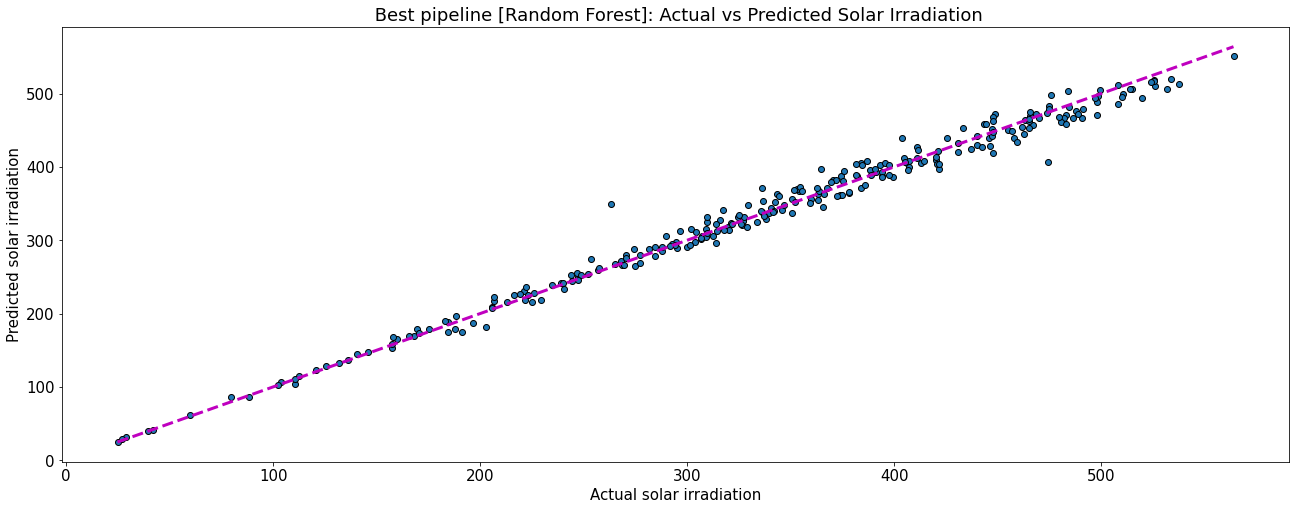

In [18]:
# run the model against the test data presented through a plot
fig, ax = plt.subplots(figsize=(22,8))

ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'm--', lw=3)
ax.set_xlabel('Actual solar irradiation')
ax.set_ylabel('Predicted solar irradiation')
ax.set_title(" Best pipeline [Random Forest]: Actual vs Predicted Solar Irradiation");

C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


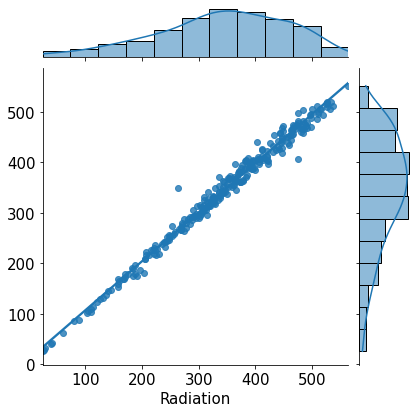

In [19]:
sns.jointplot(y_test, y_pred, kind='reg', ax=ax)
plt.show()